In [ ]:
##This Notebook closely follows the Qiskit Textbook section on VQE available here:
# https://qiskit.org/textbook/ch-applications/vqe-molecules.html

In [1]:
#Implementation of single-qubit VQE - random probability vector
#First generate our random probability vector:
import numpy as np
np.random.seed(999999)
target_distr = np.random.rand(2)
# We now convert the random vector into a valid probability vector
target_distr /= sum(target_distr)

In [2]:
#We create a qiskit based function that takes input parameters of our U3 variational form
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
def get_var_form(params):
    qr = QuantumRegister(1, name="q") #creates single qubit in our system
    cr = ClassicalRegister(1, name='c') #creates a single classical bit in our system
    qc = QuantumCircuit(qr, cr) #adds the qubit and bit into a circuit
    qc.u3(params[0], params[1], params[2], qr[0]) #defines the U3 transformation according to input parameters
    qc.measure(qr, cr[0]) #measures qubit0 using our bit
    return qc

In [3]:
from qiskit import Aer, execute
backend = Aer.get_backend("qasm_simulator") #Aer is one of the built-in Qiskit simulators, the QASM simulator simulates quantum circuits as if they were being measured on a real device
#QASM returns measurement counts, and contains a number of implementable noise mocels

NUM_SHOTS = 10000

def get_probability_distribution(counts): #this function creates a probability distribution of the measured values from the QASM simulation
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    return output_distr

def objective_function(params): 
    qc = get_var_form(params) # Create a quantum circuit from the paramters
    result = execute(qc, backend, shots=NUM_SHOTS).result()    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters using the QASM simulator as the backend
    output_distr = get_probability_distribution(result.get_counts(qc))     # Obtain the counts for each measured state, and convert those counts into a probability vector
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(2)]) # Calculate the cost as the distance between the output distribution and the target distribution
    return cost

In [4]:
from qiskit.aqua.components.optimizers import COBYLA #Qiskit Aqua is the quantum algorithm package, COBYLA stands for 'Constraint optimization by linear approximation '

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
params = np.random.rand(3)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)

# Obtain the output distribution using the final parameters
qc = get_var_form(ret[0])
counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

Target Distribution: [0.51357006 0.48642994]
Obtained Distribution: [0.5218, 0.4782]
Output Error (Manhattan Distance): 0.008059881261160806
Parameters Found: [ 1.611443   -0.20709307  2.06612738]


In [5]:
#Now we move into a 
from qiskit.aqua.algorithms import VQE, ExactEigensolver
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [8]:
#create a function that maps interatomic distance onto qubit configuration
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g') #Defining the interatomic distance and the driver
    molecule = driver.run()
    freeze_list = [0] #Freezing the cores of the atoms
    remove_list = [-3, -2] #Removing unoccupied levels
    repulsion_energy = molecule.nuclear_repulsion_energy #Implementing the nuclear repulsion of atoms within molecule
    num_particles = molecule.num_alpha + molecule.num_beta #Defining 1 Li atom and 1 H atom
    num_spin_orbitals = molecule.num_orbitals * 2 #2 spins per orbital
    
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    
    #h1 is the 2nd quantized fermionic 1 body operator, h2 is the 2nd quantized 2 body operator
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001) #creates a weighted opterator in pauli matrix basis
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) #symmetry to reduce number of qubits used
    shift = energy_shift + repulsion_energy 
    return qubitOp, num_particles, num_spin_orbitals, shift

In [10]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 3.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = ExactEigensolver(qubitOp).run() #calculate the exact value by calculating the eigenvalues classically
    exact_energies.append(result['energy'] + shift)
    #set our initial state to be the Hartree Fock approximation
    initial_state = HartreeFock(
        qubitOp.num_qubits,
        num_spin_orbitals,
        num_particles,
        'parity'
    )
    #This trial wavefunction is a Unitary Coupled-Cluster Single and Double excitations variational form.
    var_form = UCCSD(
        qubitOp.num_qubits,
        depth=1,
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    results = vqe.run(backend)['energy'] + shift
    vqe_energies.append(results)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", results, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")


Interatomic Distance: 0.5 VQE Result: -7.039710213553673 Exact Energy: -7.039732521635206
Interatomic Distance: 0.6 VQE Result: -7.313344302647484 Exact Energy: -7.313345828761001
Interatomic Distance: 0.7 VQE Result: -7.50092109608283 Exact Energy: -7.500922090905933
Interatomic Distance: 0.8 VQE Result: -7.6309769146783735 Exact Energy: -7.63097824933321
Interatomic Distance: 0.9 VQE Result: -7.7208107948909355 Exact Energy: -7.720812412134783
Interatomic Distance: 1.0 VQE Result: -7.78224065547107 Exact Energy: -7.782242402637011
Interatomic Distance: 1.1 VQE Result: -7.823597493375828 Exact Energy: -7.823599276362813
Interatomic Distance: 1.2 VQE Result: -7.850696622509608 Exact Energy: -7.850698377596025
Interatomic Distance: 1.3 VQE Result: -7.86756160215981 Exact Energy: -7.867563290110053
Interatomic Distance: 1.4 VQE Result: -7.876999876260844 Exact Energy: -7.877001491818364
Interatomic Distance: 1.5 VQE Result: -7.88101417383932 Exact Energy: -7.8810157156469955
Interatomic 

In [11]:
print('number of qubits = ', qubitOp.num_qubits)
print(num_particles)
print(num_spin_orbitals)

number of qubits =  4
2
6


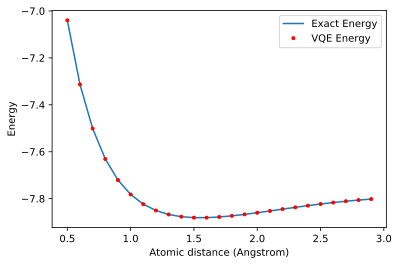

In [12]:
plt.plot(distances, exact_energies,label="Exact Energy")
plt.plot(distances, vqe_energies,'r.' , label="VQE Energy", )
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()